In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load the dataset
away_data = pd.read_csv('/content/AwayTeam.csv')

away_data.head()

,Unnamed: 0.1,Unnamed: 0,PitcherTeam,PitcherThrows,BatterSide,Outs,Balls,Strikes,TaggedPitchType,NextPitch,...,VertApprAngle,HorzApprAngle,ExitSpeed,Angle,Direction,HitSpinRate,Distance,Bearing,HangTime,Game#
0,14,14,WHI_COL1,Right,Left,0,0,0,Fastball,Fastball,...,-8.175033,-0.568872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,15,15,WHI_COL1,Right,Left,0,1,0,Fastball,Fastball,...,-8.280537,-1.212859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,16,16,WHI_COL1,Right,Left,0,2,0,Fastball,Fastball,...,-6.740462,-1.682767,97.23394,7.727534,25.755927,1839.754769,120.81491,28.100461,0.966997,1
3,17,17,WHI_COL1,Right,Right,0,0,0,Fastball,Fastball,...,-6.615093,-2.150133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,18,18,WHI_COL1,Right,Right,0,0,1,Fastball,Fastball,...,-7.260115,-0.060418,21.69942,-38.980775,-0.157527,NaN,5.72231,-7.032169,0.088799,1


In [ ]:
# Create the AdvantageCount variable
def determine_advantage(balls, strikes):
    if balls > strikes:
        return 1  # Batter advantage
    else:
        return 0  # No advantage or pitcher advantage

away_data['AdvantageCount'] = away_data.apply(lambda row: determine_advantage(row['Balls'], row['Strikes']), axis=1)

# Ensure there are no missing values in relevant columns
away_data.dropna(subset=['PitcherThrows', 'BatterSide'], inplace=True)

# Add "SameSide" variable
def determine_same_side(row):
    return 1 if row['PitcherThrows'] == row['BatterSide'] else 0

away_data['SameSide'] = away_data.apply(determine_same_side, axis=1)

In [ ]:
# Drop rows with missing values for required columns
away_data.dropna(subset=['TaggedPitchType', 'PlateLocHeight', 'PlateLocSide', 'Balls', 'Strikes', 'SameSide'], inplace=True)

# Define predictors and response variables
feature_columns = ['PlateLocHeight', 'PlateLocSide']
context_columns = ['AdvantageCount', 'SameSide']
pitch_column = 'TaggedPitchType'

# Encode pitch types as integers
pitch_mapping = {pitch: i for i, pitch in enumerate(away_data[pitch_column].unique())}
away_data[pitch_column] = away_data[pitch_column].map(pitch_mapping)

# Reverse mapping for decoding
reverse_mapping = {v: k for k, v in pitch_mapping.items()}

# Create sequences
sequence_length = 5

def create_sequences(data, sequence_length):
    X_pitches, X_features, y = [], [], []
    for i in range(len(data) - sequence_length):
        pitch_seq = data[pitch_column].iloc[i:i + sequence_length].values
        feature_seq = data[feature_columns].iloc[i:i + sequence_length].values
        next_pitch = data[pitch_column].iloc[i + sequence_length]
        X_pitches.append(pitch_seq)
        X_features.append(feature_seq)
        y.append(next_pitch)
    return np.array(X_pitches), np.array(X_features), np.array(y)

X_pitches, X_features, y = create_sequences(away_data, sequence_length)

# One-hot encode the target variable
num_classes = len(pitch_mapping)
y = to_categorical(y, num_classes=num_classes)

# Preprocess features
feature_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_columns)
    ]
)

# Split into train/test sets
X_pitches_train, X_pitches_test, X_features_train, X_features_test, y_train, y_test = train_test_split(X_pitches, X_features, y, test_size=0.3, random_state=21)

# Convert location data back to DataFrame for ColumnTransformer
X_features_train_df = pd.DataFrame(X_features_train.reshape(-1, len(feature_columns)), columns=feature_columns)

X_features_test_df = pd.DataFrame(X_features_test.reshape(-1, len(feature_columns)), columns=feature_columns)

# Apply the preprocessor
X_features_train_processed = feature_preprocessor.fit_transform(X_features_train_df)
X_features_test_processed = feature_preprocessor.transform(X_features_test_df)

# Reshape back to sequence format
X_features_train = X_features_train_processed.reshape(X_features_train.shape[0], sequence_length, len(feature_columns))
X_features_test = X_features_test_processed.reshape(X_features_test.shape[0], sequence_length, len(feature_columns))

# Define the inputs for the model
pitch_input = Input(shape=(sequence_length,), name='Pitch_Input')
location_input = Input(shape=(sequence_length, len(feature_columns)), name='Location_Input')
context_input = Input(shape=(len(context_columns),), name='Context_Input')

# Embedding and LSTM for pitch input
pitch_embedding = Embedding(input_dim=num_classes, output_dim=16, name='Pitch_Embedding')(pitch_input)
pitch_lstm = LSTM(64, return_sequences=False, name='Pitch_LSTM')(pitch_embedding)
pitch_dropout = Dropout(0.3, name='Pitch_Dropout')(pitch_lstm)

# LSTM for location input
location_lstm = LSTM(64, return_sequences=False, name='Location_LSTM')(location_input)
location_dropout = Dropout(0.3, name='Location_Dropout')(location_lstm)

# Combine LSTM outputs and context input
combined = Concatenate(name='Combined_Layer')([pitch_dropout, location_dropout, context_input])

# Dense layers
dense1 = Dense(64, activation='relu', name='Dense1')(combined)
dense_dropout = Dropout(0.3, name='Dense_Dropout')(dense1)
output = Dense(num_classes, activation='softmax', name='Output_Layer')(dense_dropout)

# Encapsulating the model in one singular block
model = Model(inputs=[pitch_input, location_input, context_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Prepare context input for training
context_train = X_features_train[:, -1, -len(context_columns):]  # Extract AdvantageCount and SameSide
context_test = X_features_test[:, -1, -len(context_columns):]

# Train the model
history = model.fit(
    [X_pitches_train, X_features_train, context_train], y_train,
    validation_split=0.3,
    epochs=25,
    batch_size=32,
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate([X_pitches_test, X_features_test, context_test], y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Decode predictions
y_pred = model.predict([X_pitches_test, X_features_test, context_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Map predictions back to pitch labels
y_pred_labels = [reverse_mapping[pred] for pred in y_pred_classes]
y_test_labels = [reverse_mapping[true] for true in y_test_classes]

# Display results
for i in range(10):  # Adjust range for the number of predictions you want to display
    input_sequence = [reverse_mapping.get(idx, "Unknown") for idx in X_pitches_test[i]]
    actual_label = reverse_mapping.get(y_test_classes[i], "Unknown")
    predicted_label = reverse_mapping.get(y_pred_classes[i], "Unknown")
    print(f"Input Sequence: {input_sequence}")
    print(f"Actual: {actual_label}, Predicted: {predicted_label}")
    print("---")

Epoch 1/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4289 - loss: 1.8616 - val_accuracy: 0.5607 - val_loss: 1.2858
Epoch 2/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4845 - loss: 1.3209 - val_accuracy: 0.5607 - val_loss: 1.1913
Epoch 3/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5412 - loss: 1.2362 - val_accuracy: 0.5607 - val_loss: 1.1617
Epoch 4/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5328 - loss: 1.2211 - val_accuracy: 0.5545 - val_loss: 1.1248
Epoch 5/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5513 - loss: 1.1543 - val_accuracy: 0.5668 - val_loss: 1.1252
Epoch 6/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5319 - loss: 1.1777 - val_accuracy: 0.5699 - val_loss: 1.0962
Epoch 7/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5572 - loss: 1.1466 - val_accuracy: 0.5637 - val_loss: 1.0911
Epoch 8/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5428 - loss: 1.1803 - val_accuracy: 0.5591 - val_

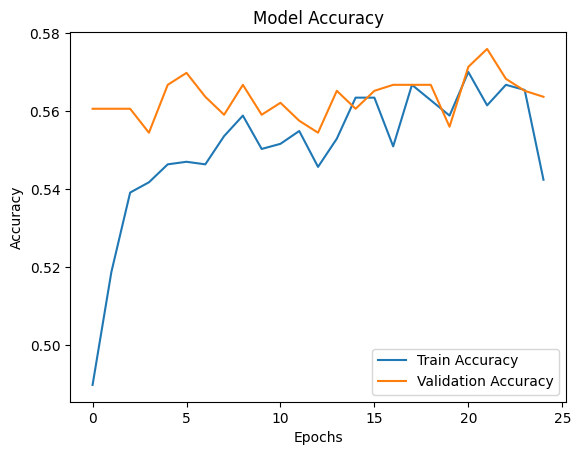

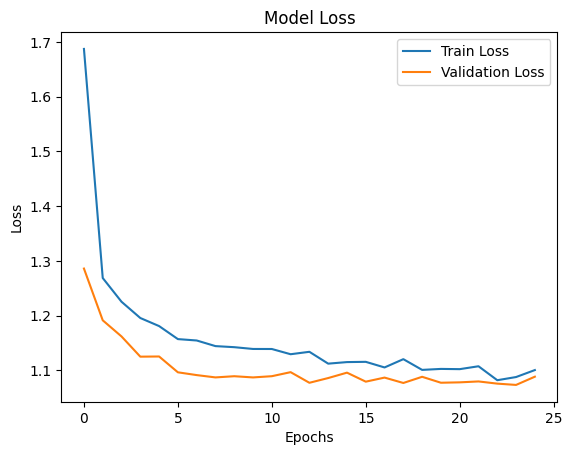

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()